Chrolopphyl absorption 

Testing OPACITY_SCHEME = "MANIZZA_05"

Gustavo Marques (gmarques@ucar.edu)

In [1]:
from datetime import date
print("Last update:", date.today())

Last update: 2020-12-03


## Summary  

* G001: Baseline - out-of-the-box (CESM2.2/MOM6 tag) 
* G002: Baseline + SW absorption via CHLA climatology (only one visible band)
* G004: Baseline + SW absorption via CHLA climatology (3 bands)

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn, matplotlib
import warnings, os
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, xyplot
import pop_tools
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

Basemap module not found. Some regional plots may not function properly


Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [3]:
path = '/glade/scratch/gmarques/'
exps = ['gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001', \
        'gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002', \
        'gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.004']

labels = ['Baseline', 'CHLA1', 'CHLA2']

# set this to true to save the plots
saveplot = False
if saveplot:
    os.system('mkdir PNG')

In [4]:
def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

In [5]:
# load grid and pre-difined masks
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


### 1.1 Globally-averaged ocean properties

../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001/ncfiles/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001_ann_ave_global_means.nc
../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002/ncfiles/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002_ann_ave_global_means.nc
../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.004/ncfiles/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.004_ann_ave_global_means.nc


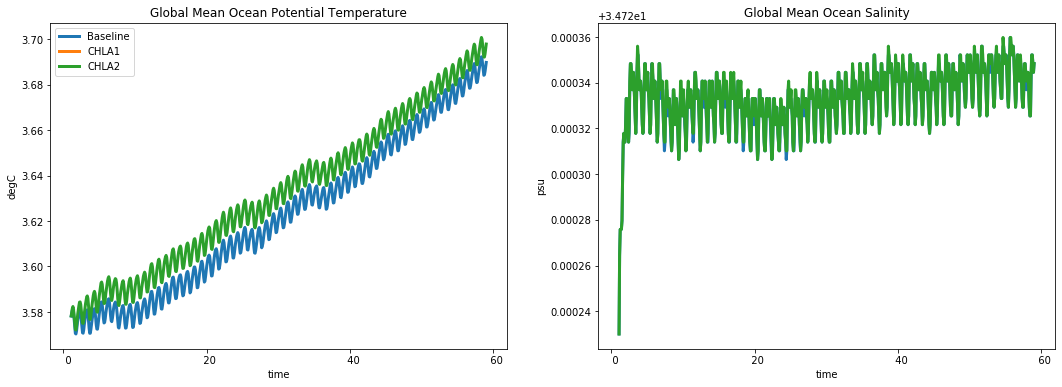

In [6]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = '../../'+exps[i]+'/ncfiles/'+exps[i]+'_ann_ave_global_means.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds.thetaoga.attrs['units'])
ax[1].set_title(ds.soga.attrs['long_name']); ax[1].set_ylabel(ds.soga.attrs['units'])
ax[0].legend()
if saveplot:
    fname = 'PNG/global_means.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

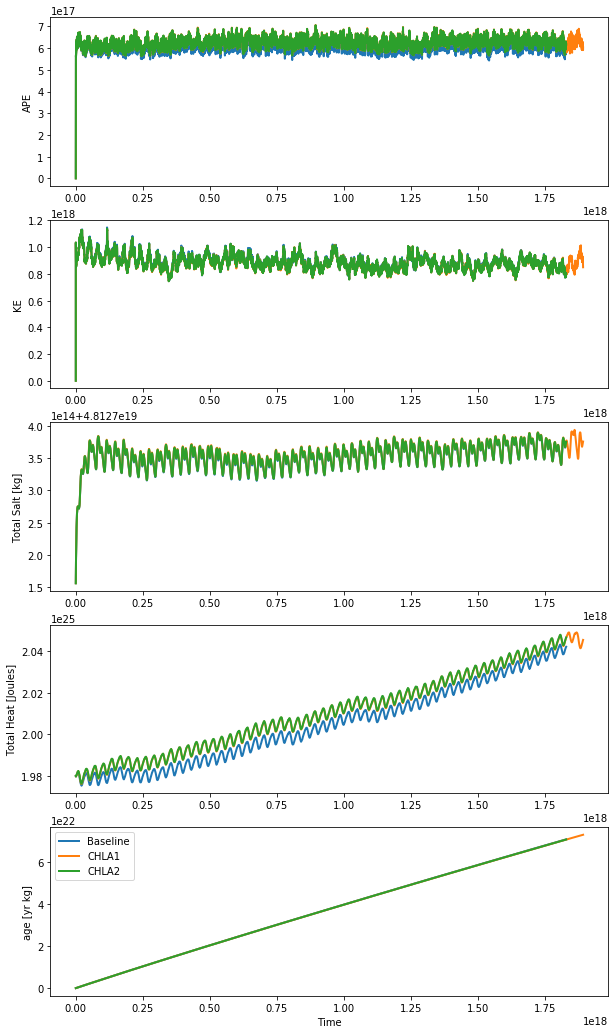

In [7]:
%matplotlib inline
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,18))
for i in range(len(exps)): 
  ds = xr.open_dataset(path+exps[i]+'/run/ocean.stats.nc')
  #ds = ds.isel(Time=range(1000, 21172))
  for var, j in zip(variables, range(len(variables))):
    if len(ds[var].shape) > 1:
        tmp = ds[var].sum(axis=1)
    else:
        tmp = ds[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=2)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()
if saveplot:
    fname = 'PNG/ocean_stats.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

### 1.2 Mixed layer depth

In [8]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


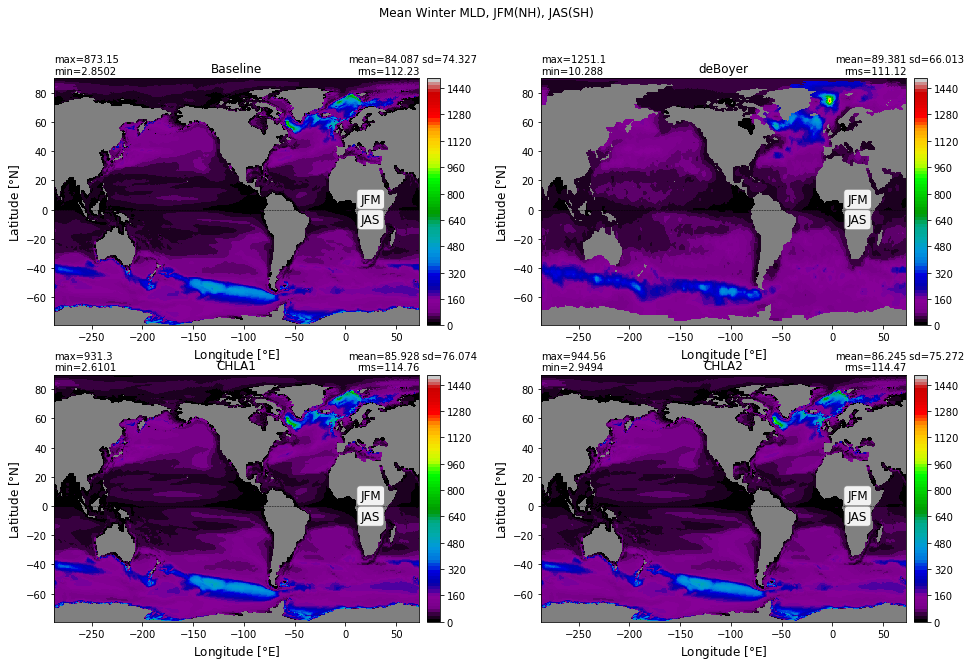

In [9]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])


xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

#diff = var - control
#xyplot(diff, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]+' - '+labels[0]), axis=ax1[3], 
#       colormap=plt.cm.bwr, nbins=20); add_labels(ax1[3])

if saveplot:
    fname = 'PNG/MLD_winter.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

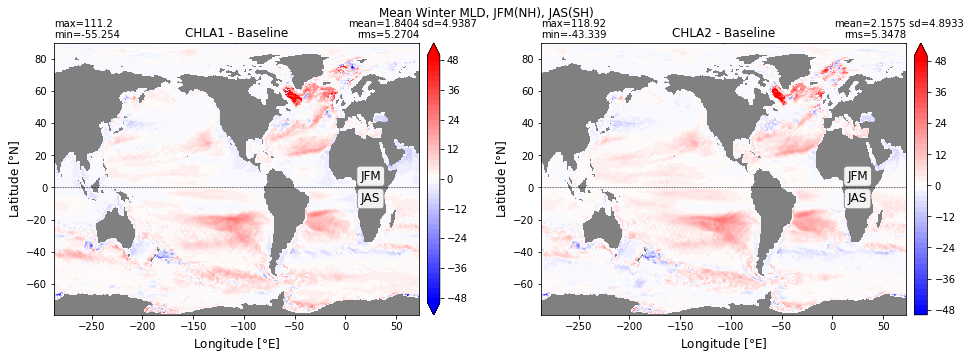

In [10]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
ds = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_MLD_winter.nc')
control = np.ma.masked_invalid(ds.MLD_winter.values)
for i in [1,2]:
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  var = np.ma.masked_invalid(ds.MLD_winter.values) -control
  xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=labels[i]+ ' - ' + labels[0], axis=ax1[i-1], clim=(-50,50),
         colormap=plt.cm.bwr, nbins=50); add_labels(ax1[i-1])

if saveplot:
    fname = 'PNG/MLD_winter_comparison.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

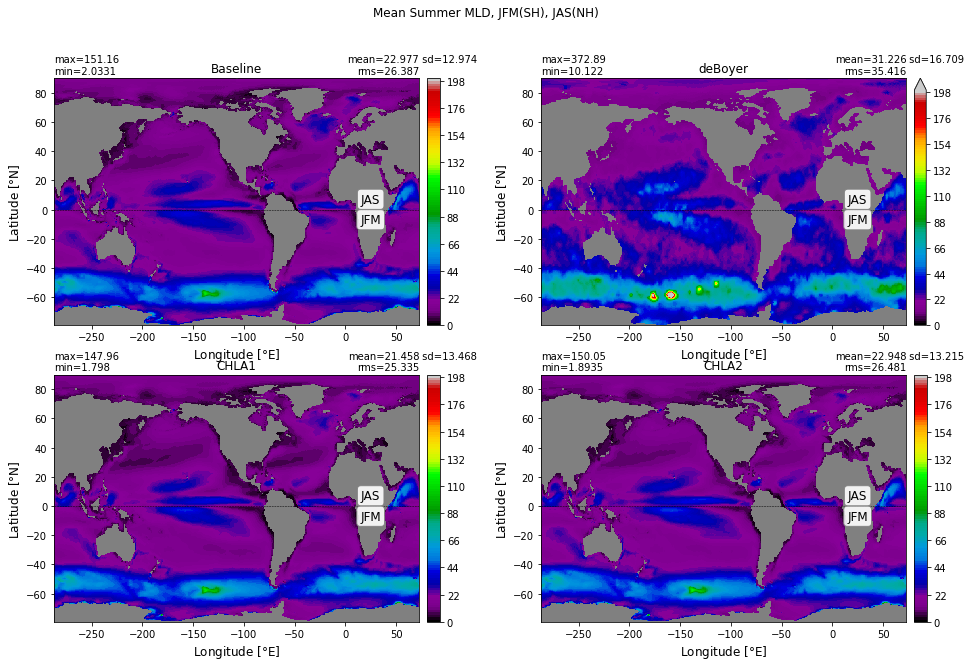

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

#diff = var - control
#xyplot(diff, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]+' - '+labels[0]), axis=ax1[3], 
#       colormap=plt.cm.bwr, nbins=20); add_labels(ax1[3], sh='JFM', nh='JAS')

if saveplot:
    fname = 'PNG/MLD_summer.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

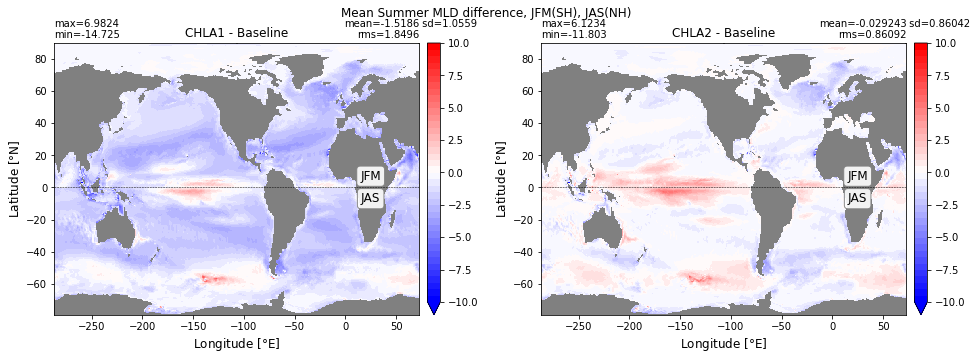

In [12]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD difference, JFM(SH), JAS(NH)')
ds = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_MLD_summer.nc')
control = np.ma.masked_invalid(ds.MLD_summer.values)
for i in [1,2]:
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  var = np.ma.masked_invalid(ds.MLD_summer.values) -control
  xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=labels[i]+ ' - ' + labels[0], axis=ax1[i-1], 
         clim=(-10,10),
         colormap=plt.cm.bwr, nbins=50); add_labels(ax1[i-1])

if saveplot:
    fname = 'PNG/MLD_summer_comparison.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

###  1.3 Poleward Heat Transport

In [13]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

In [14]:
def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

<center> <font size="4">Global Heat Transport</font>

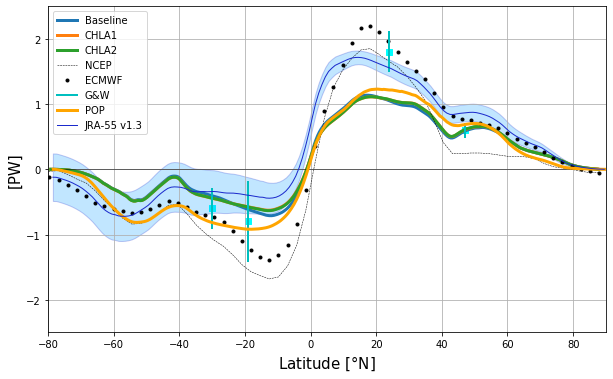

In [15]:
# Global Heat Transport
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds)
  HT = heatTrans(adv,diff); y = ds.yq
  plt.plot(y, HT, linewidth=3,label=labels[i]); 
    
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); 
plt.plot(y, y*0., 'k', linewidth=0.5)
plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF')
plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err'])
pop = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/MHT_mean.g210.GIAF_JRA.v13.gx1v7.01.nc')
jra = xr.open_dataset('/glade/work/gmarques/cesm/datasets/Heat_transport/jra55fcst_v1_3_annual_1x1/nht_jra55do_v1_3.nc')
plt.plot(pop.lat_aux_grid.values,pop.MHT_global.values,'orange',linewidth=3,label='POP')
jra_mean_global = jra.nht[:,0,:].mean('time').values
jra_std_global = jra.nht[:,0,:].std('time').values
plt.plot(jra.lat, jra_mean_global,'k', label='JRA-55 v1.3', color='#1B2ACC', lw=1)
plt.fill_between(jra.lat, jra_mean_global-jra_std_global, jra_mean_global+jra_std_global,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15)
plt.legend(loc=0,fontsize=10)
plt.ylim(-2.5,2.5)
if saveplot:
    fname = 'PNG/global_poleward_heat_transport.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

In [16]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth)

11.16427964664149 64.78854837178643 [391, 434]


<center> <font size="4">Atlantic Heat Transport</font>

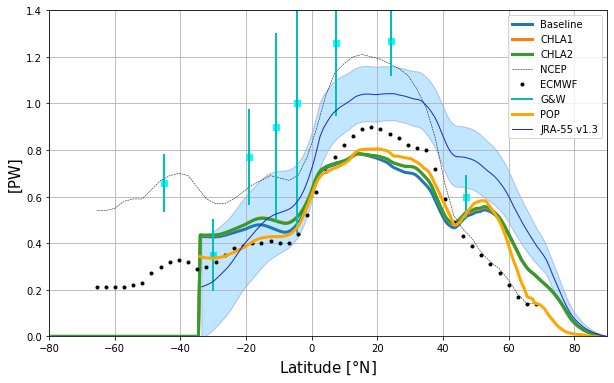

In [17]:
# Atlantic Heat Transport
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)] = 1
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds)
  HT = heatTrans(adv,diff, vmask=m*np.roll(m,-1,axis=-2)); y = ds.yq
  plt.plot(y, HT, linewidth=3,label=labels[i])
    
plt.xlim(-80,90); plt.ylim(-0.1,2.0)
plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5)
plt.plot(yobs,NCEP['Atlantic'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Atlantic'],'k.',linewidth=0.5,label='ECMWF'); 
plotGandW(GandW['Atlantic']['lat'],GandW['Atlantic']['trans'],GandW['Atlantic']['err'])

plt.plot(pop.lat_aux_grid.values,pop.MHT_atl.values,'orange',linewidth=3,label='POP')
jra_mean_atl = jra.nht[:,1,:].mean('time').values
jra_std_atl = jra.nht[:,1,:].std('time').values
plt.plot(jra.lat, jra_mean_atl,'k', label='JRA-55 v1.3', color='#1B2ACC', lw=1)
plt.fill_between(jra.lat, jra_mean_atl-jra_std_atl, jra_mean_atl+jra_std_atl,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(0,1.4)
if saveplot:
    fname = 'PNG/atlantic_poleward_heat_transport.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

### 1.4 Meridional Overturning Circulation

#### AMOC time series @ 26N and 45N

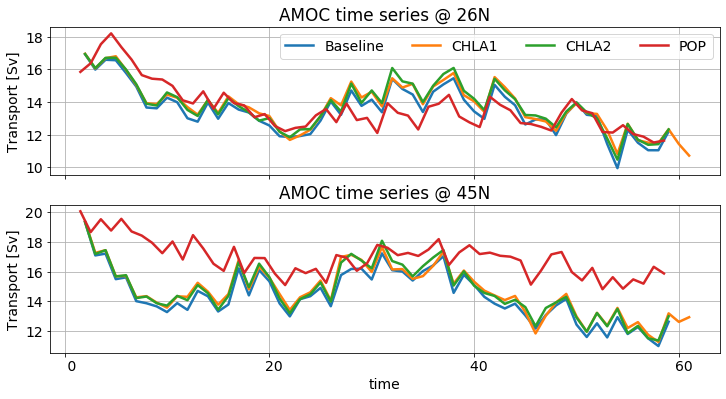

In [18]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
for i in range(len(exps)):
  ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC.nc')
  ds1.amoc_26.plot(ax=ax[0], label=labels[i], lw=2.5)
  ds2 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC.nc')
  ds2.amoc_45.plot(ax=ax[1], label=labels[i], lw=2.5)


# load AMOC from POP JRA-55
amoc_pop_26 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
            'AMOC_series_26n.g210.GIAF_JRA.v13.gx1v7.01.nc').sel(time=slice('0001-01-01', '0059-01-01'))
amoc_pop_26.AMOC_26n.plot(ax=ax[0], label='POP', lw=2.5)

amoc_pop_45 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
            'AMOC_series_45n.g210.GIAF_JRA.v13.gx1v7.01.nc').sel(time=slice('0001-01-01', '0059-01-01'))
amoc_pop_45.AMOC_45n.plot(ax=ax[1], label='POP', lw=2.5)


ax[0].set_ylabel('Transport [Sv]'); ax[0].legend(ncol=5); ax[0].set_title('AMOC time series @ 26N')
ax[0].set_xlabel('');ax[0].grid()
ax[1].set_ylabel('Transport [Sv]'); ax[1].set_title('AMOC time series @ 45N');ax[1].grid()

if saveplot:
    fname = 'PNG/AMOC_time_series.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

#### AMOC Profile @ 26N

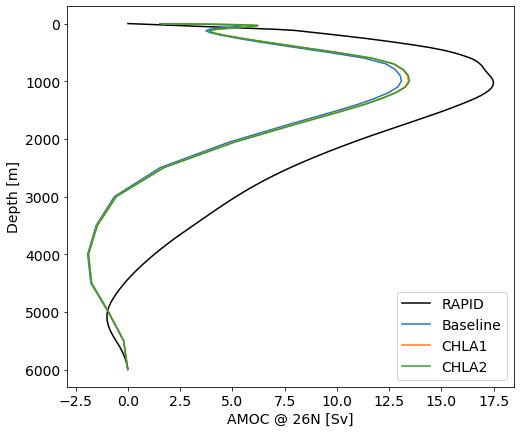

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
rapid_vertical = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_vertical.nc')
ax.plot(rapid_vertical.stream_function_mar.mean('time'), rapid_vertical.depth, 'k', label='RAPID')
for i in range(len(exps)):
  ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC.nc')
  ax.plot(ds1['amoc'].sel(yq=26, method='nearest'), ds1.zl, label=labels[i])
  #
  #plt.grid()
  
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]')
ax.legend()
plt.gca().invert_yaxis()

### 1.5 Transports

In [20]:
ds = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_section_transports.nc')

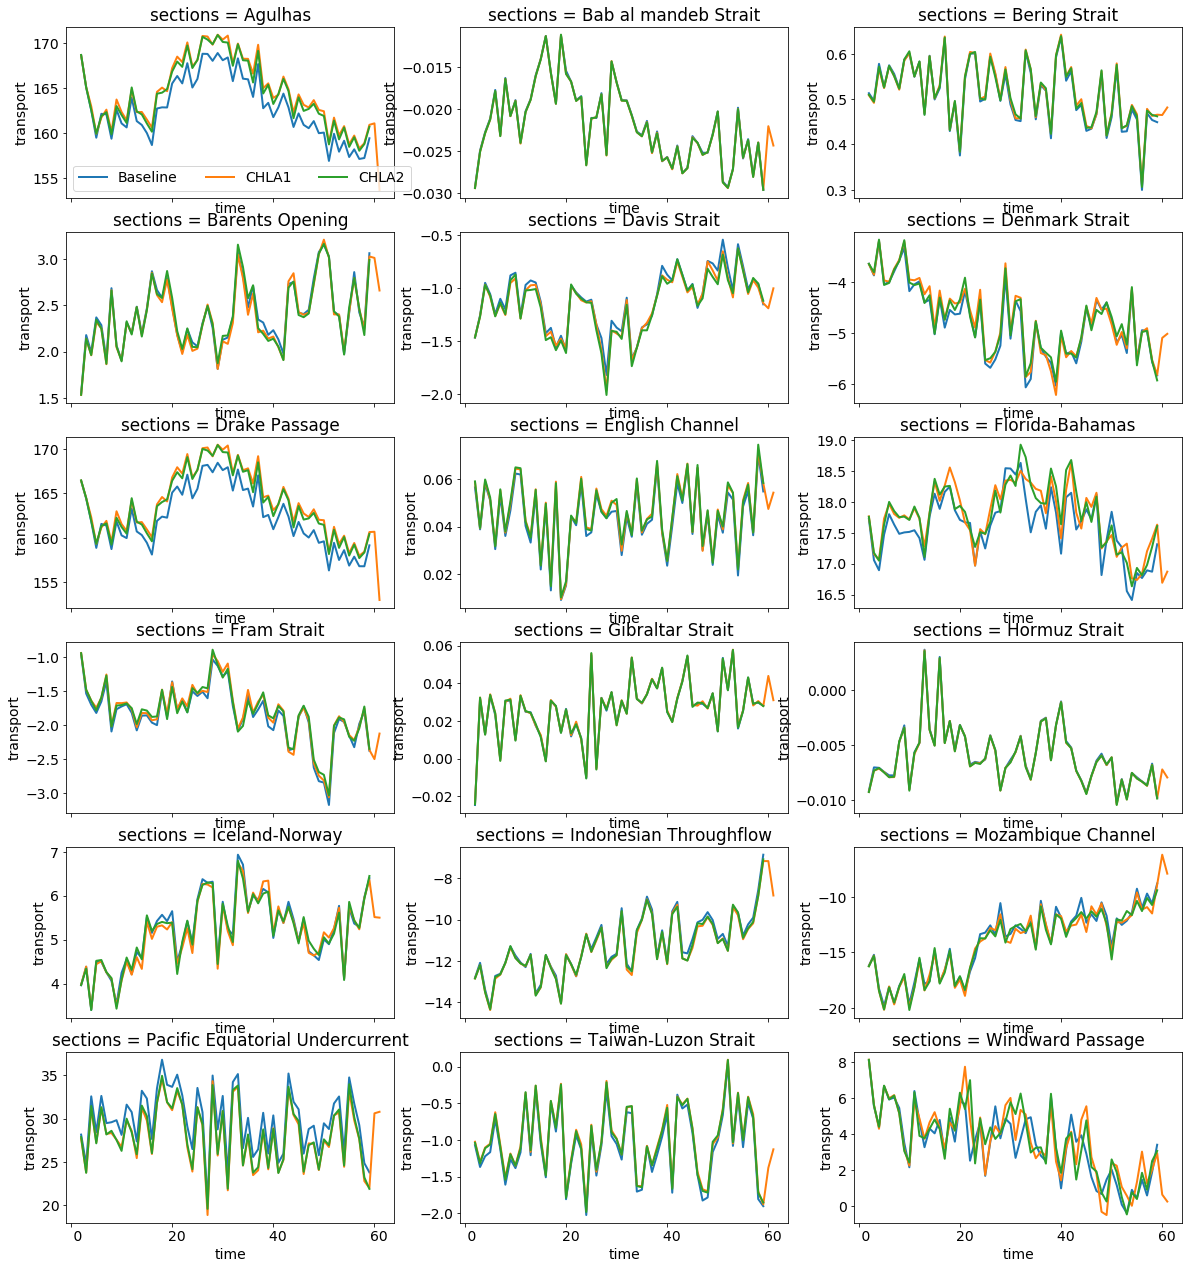

In [21]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,22), sharex=True)
ax1 = ax.flatten()
for p in range(len(ds.sections)):
  for i in range(len(exps)):
    ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
    ds.transport.isel(sections=p).plot(ax=ax1[p], label=labels[i], lw=2)

ax1[0].legend(ncol=4)

### 1.6 Horizontal Mean bias versus time

In [22]:
start_date ='0001-01-01'
end_date   ='0059-01-01'

In [23]:
i=0
ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
ds.region

<xarray.DataArray 'region' (region: 11)>
array(['Global', 'MedSea', 'BalticSea', 'HudsonBay', 'Arctic', 'PacificOcean',
       'AtlanticOcean', 'IndianOcean', 'SouthernOcean', 'LabSea', 'BaffinBay'],
      dtype=object)
Coordinates:
  * region   (region) object 'Global' 'MedSea' ... 'LabSea' 'BaffinBay'

TypeError: Dimensions of C (34, 31) are incompatible with X (58) and/or Y (34); see help(pcolormesh)

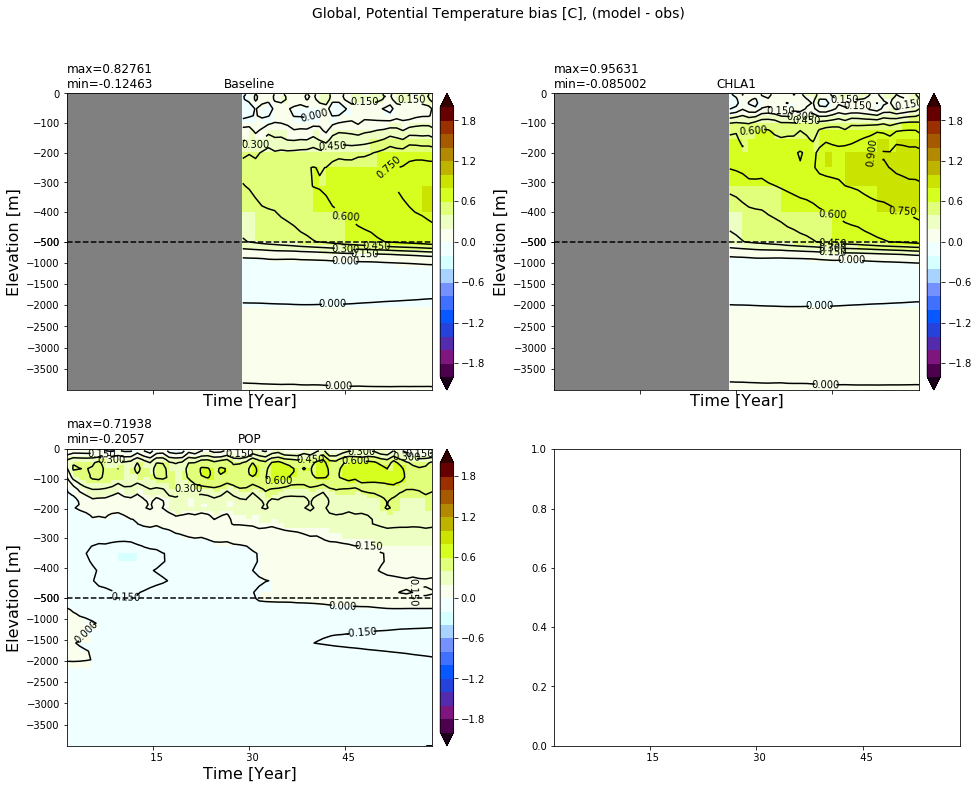

In [24]:
%matplotlib inline
reg_mom = ['Global','SouthernOcean','PacificOcean','IndianOcean','AtlanticOcean','Arctic','LabSea']
reg_pop = [0,1,2,3,6,10,8]

ds_mom1 = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_temp_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
ds_mom2 = xr.open_dataset('../../'+exps[1]+'/ncfiles/'+exps[1]+'_temp_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
ds_mom3 = xr.open_dataset('../../'+exps[2]+'/ncfiles/'+exps[2]+'_temp_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
ds_pop = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_temp_bias.nc').sel(time=slice(start_date, 
                                                                                                           end_date))
    
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
  plt.suptitle(str(m)+', Potential Temperature bias [C], (model - obs)', fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom1 = np.ma.masked_invalid(ds_mom1.sel(region=m).temp_bias.values)
  dummy_mom2 = np.ma.masked_invalid(ds_mom2.sel(region=m).temp_bias.values)
  dummy_mom3 = np.ma.masked_invalid(ds_mom2.sel(region=m).temp_bias.values)
  dummy_pop = np.ma.masked_invalid(ds_pop.__xarray_dataarray_variable__.sel(region=str(p)).values)

  dummy_pop = np.ma.masked_invalid(ds_pop.sel(region=str(p)).__xarray_dataarray_variable__.values)

  ztplot(dummy_mom1, ds_mom1.time.values, ds_mom1.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[0] , title=labels[0], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-2, 2)) 

  ztplot(dummy_mom2, ds_mom2.time.values, ds_mom2.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[1] , title=labels[1], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-2, 2))
    
  ztplot(dummy_pop, ds_pop.time.values, -ds_pop.z_l.values/100., ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[2] , title='POP', extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-2, 2))

  ztplot(dummy_mom2, ds_mom3.time.values, ds_mom3.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[3] , title=labels[2], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-2, 2))

  #ztplot(dummy_mom2-dummy_mom1, ds_mom2.time.values, ds_mom2.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
  #       contour=True, axis=ax.flat[3] , title=labels[1] + ' - ' + labels[0], extend='both', colormap='bwr', 
  #       autocenter=True, tunits='Year')

  if saveplot:
    fname = 'PNG/temp_bias_mom_pop.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)  

In [ ]:
%matplotlib inline
reg_mom = ['Global','SouthernOcean','PacificOcean','IndianOcean','AtlanticOcean','Arctic','LabSea']
reg_pop = [0,1,2,3,6,10,8]

ds_mom1 = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_salt_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
ds_mom2 = xr.open_dataset('../../'+exps[1]+'/ncfiles/'+exps[1]+'_salt_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
ds_mom3 = xr.open_dataset('../../'+exps[2]+'/ncfiles/'+exps[2]+'_salt_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))

ds_pop = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_salt_bias.nc').sel(time=slice(start_date, 
                                                                                                           end_date))
    
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
  plt.suptitle(str(m)+', Salinity bias [psu], (model - obs)', fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom1 = np.ma.masked_invalid(ds_mom1.sel(region=m).salt_bias.values)
  dummy_mom2 = np.ma.masked_invalid(ds_mom2.sel(region=m).salt_bias.values)
  dummy_mom3 = np.ma.masked_invalid(ds_mom3.sel(region=m).salt_bias.values)
  dummy_pop = np.ma.masked_invalid(ds_pop.__xarray_dataarray_variable__.sel(region=str(p)).values)

  dummy_pop = np.ma.masked_invalid(ds_pop.sel(region=str(p)).__xarray_dataarray_variable__.values)

  ztplot(dummy_mom1, ds_mom1.time.values, ds_mom1.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[0] , title=labels[0], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-.2, .2)) 

  ztplot(dummy_mom2, ds_mom2.time.values, ds_mom2.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[1] , title=labels[1], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-.2, .2))
    
  ztplot(dummy_pop, ds_pop.time.values, -ds_pop.z_l.values/100., ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[2] , title='POP', extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-.2, .2))

  ztplot(dummy_mom3, ds_mom3.time.values, ds_mom3.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[3] , title=labels[2], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=(-.2, .2))
  #ztplot(dummy_mom2-dummy_mom1, ds_mom2.time.values, ds_mom2.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
  #       contour=True, axis=ax.flat[3] , title=labels[1] + ' - ' + labels[0], extend='both', colormap='bwr', 
  #       autocenter=True, tunits='Year')

  if saveplot:
    fname = 'PNG/salt_bias_mom_pop.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)  

### 1.9 Solar Short-Wave Heat Flux

In [ ]:
ds_pop_grid = pop_tools.get_grid('POP_gx1v7')

exp_name_pop = 'g210.GIAF_JRA.v13.gx1v7.01'
date_str_pop = '0058'
pop_label = 'POP GIAF_JRA.01 ' + date_str_pop
path_pop_root = '/glade/p/cgd/oce/projects/JRA55/IAF/' + exp_name_pop + '/'
path_pop_hist = path_pop_root + 'ocn/hist/'
path_pop_tavg = path_pop_root + 'ocn/proc/tavg/annual/'
file_tavg = exp_name_pop + '.pop.h.' + date_str_pop + '.nc'


In [ ]:
def pop_add_cyclic(ds):

    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.

    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))

    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})

    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'),
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})


    return dso

In [ ]:
grid_o = pop_add_cyclic(ds_pop_grid)

In [ ]:
ds_pop = pop_add_cyclic(xr.open_dataset(path_pop_tavg+file_tavg))
ds_pop['z_w_top']=ds_pop.z_w_top / 100. # in m
#ds_pop.assign_coords(TLAT=(['nlat','nlon'], ds_pop.TLAT))
#ds_pop.assign_coords(TLONG=(['nlat','nlon'], ds_pop.TLONG))
                     
# QSW_HTP = Solar Short-Wave Heat Flux in top layer
# QSW_3D = Solar Short-Wave Heat Flux
# SHF_QSW = Solar Short-Wave Heat Flux

In [ ]:
exps

In [ ]:
ds_mom = get_data(path+exps[2]+'/run/'+exps[2]+'.mom6.hm_0058_??.nc', ['rsdo','nonpenSW','rsntds',
                                                                       'Chl_opac','rsdoabsorb','SW_vis_pen',
                                                                      'SW_pen','opac_1','opac_2','opac_2'])

#ds_mom_59 = get_data(path+exps[1]+'/run/'+exps[1]+'.mom6.hm_0059_??.nc', ['rsdo','nonpenSW','rsntds',
#                                                                       'Chl_opac','rsdoabsorb'])
#nonpenSW = SW absorbed in ocean surface with LW,SENS,LAT
#rsdo = Downwelling Shortwave Flux in Sea Water at Grid Cell Upper Interface
#Chl_opac = Surface chlorophyll A concentration used to find opacity
# rsdoabsorb = Convergence of Penetrative Shortwave Flux in Sea Water Layer
# rsntds = Net Downward Shortwave Radiation at Sea Water Surface 
# SW_vis_pen = Visible penetrating shortwave radiation flux into ocean
# SW_pen = Penetrating shortwave radiation flux into ocean
# opac_? = Opacity for shortwave radiation in band ?, saved as L^-1 tanh(Opacity * L) for L = 10^-10 m

#### Total SW flux at the surface in MOM6 and POP at year 58 

In [ ]:
%matplotlib inline
grid_o = pop_add_cyclic(ds_pop_grid)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
ax1 = ax.flatten()
sw_mom = np.ma.masked_invalid(ds_mom.rsntds.mean(dim='time').values)
sw_pop = np.ma.masked_invalid(ds_pop.SHF_QSW[0,:].values)
  
plt.suptitle('Net Downward Shortwave Radiation at Sea Water Surface')
xyplot(sw_mom, grd.geolon, grd.geolat, grd.area_t, title='mom6', axis=ax1[0], 
       clim=(0,270), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

xyplot(sw_pop, grid_o.TLONG.values, grid_o.TLAT.values, grid_o.TAREA.values, 
       title='pop', axis=ax1[1], 
       clim=(0,270), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

ax1[1].set_xlim(-220,140)

#### SW_vis_pen and SW_pen in MOM6 at year 58 

In [ ]:
%matplotlib inline
grid_o = pop_add_cyclic(ds_pop_grid)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.5))
ax1 = ax.flatten()
SW_vis_pen = np.ma.masked_invalid(ds_mom.SW_vis_pen.mean(dim='time').values)
SW_pen = np.ma.masked_invalid(ds_mom.SW_pen.mean(dim='time').values)

plt.suptitle('SW_vis_pen = Visible penetrating SW flux; SW_pen = Penetrating SW flux')
  
xyplot(SW_vis_pen, grd.geolon, grd.geolat, grd.area_t, title='SW_vis_pen', axis=ax1[0], 
       clim=(0,270), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

xyplot(SW_pen, grd.geolon, grd.geolat, grd.area_t, title='SW_pen', axis=ax1[1], 
       clim=(0,270), nbins=100, colormap=plt.cm.bwr, centerlabels=True)


#### SW_pen + SW_vis_pen versus rsdo at year 58 

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.5))
ax1 = ax.flatten()
sw_pen_diff = np.ma.masked_invalid((ds_mom.SW_pen.mean(dim='time')-ds_mom.SW_vis_pen.mean(dim='time')).values)
rsdo = np.ma.masked_invalid(ds_mom.rsdo.mean(dim='time')[0,:].values)
  
#rsdo = downwelling SW Flux in Sea Water at Grid Cell Upper Interface
#QSW_HTP = Solar Short-Wave Heat Flux in top layer
xyplot(sw_pen_diff, grd.geolon, grd.geolat, grd.area_t, title='SW_pen - SW_vis_pen', axis=ax1[0], 
       clim=(0,250), nbins=50, colormap=plt.cm.bwr, centerlabels=True)
xyplot(rsdo, grd.geolon, grd.geolat, grd.area_t, title='rsdo', axis=ax1[1], 
       clim=(0,250), nbins=50, colormap=plt.cm.bwr, centerlabels=True)

#### Define pts for vertical profiles

In [ ]:
#mom
mom_i = []; mom_j = []
mom_i.append(np.abs(grd.xh + 120.).argmin())
mom_i.append(np.abs(grd.xh + 120.).argmin())
mom_i.append(np.abs(grd.xh + 63.).argmin())
mom_j.append(np.abs(grd.yh - 0.).argmin())
mom_j.append(np.abs(grd.yh + 30.).argmin())
mom_j.append(np.abs(grd.yh + 50.).argmin())

# pop
pop_i = []; pop_j = []
pop_i.append(np.abs(ds_pop.TLONG[0,:] + 120.).argmin().values)
pop_i.append(np.abs(ds_pop.TLONG[0,:] + 120.).argmin().values)
pop_i.append(np.abs(ds_pop.TLONG[0,:] + 63.).argmin().values)
pop_j.append(np.abs(ds_pop.lat_aux_grid - 0.).argmin().values)
pop_j.append(np.abs(ds_pop.lat_aux_grid + 30.).argmin().values)
pop_j.append(np.abs(ds_pop.lat_aux_grid + 50.).argmin().values)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5.5))
var = np.ma.masked_invalid(ds_mom.Chl_opac.mean(dim='time').values)
xyplot(np.log10(var), grd.geolon, grd.geolat, grd.area_t, title='CHLA mean', axis=ax, nbins=10)
#ds_mom.Chl_opac.mean(dim='time').plot(ax=ax,vmin=0.,vmax=1)
ax.plot(grd.geolon[mom_j[0],mom_i[0]], grd.geolat[mom_j[0],mom_i[0]],'ro',ms=5)
ax.plot(grd.geolon[mom_j[1],mom_i[1]], grd.geolat[mom_j[1],mom_i[1]],'ro',ms=5)
ax.plot(grd.geolon[mom_j[2],mom_i[2]], grd.geolat[mom_j[2],mom_i[2]],'ro',ms=5)

#### Compare SW at the top-most interfaces

In [ ]:
%matplotlib inline
grid_o = pop_add_cyclic(ds_pop_grid)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.5))
ax1 = ax.flatten()
sw_mom = np.ma.masked_invalid(ds_mom.rsdo.mean(dim='time')[0,:].values)
sw_pop = np.ma.masked_invalid(ds_pop.QSW_3D[0,0,:,:].values)
  
#rsdo = downwelling SW Flux in Sea Water at Grid Cell Upper Interface
#QSW_HTP = Solar Short-Wave Heat Flux in top layer
xyplot(sw_mom, grd.geolon, grd.geolat, grd.area_t, title='mom6', axis=ax1[0], 
       clim=(0,250), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
ax[0].plot(grd.geolon[mom_j[0],mom_i[0]], grd.geolat[mom_j[0],mom_i[0]],'ko',ms=5)
ax[0].plot(grd.geolon[mom_j[1],mom_i[1]], grd.geolat[mom_j[1],mom_i[1]],'ko',ms=5)
ax[0].plot(grd.geolon[mom_j[2],mom_i[2]], grd.geolat[mom_j[2],mom_i[2]],'ko',ms=5)

xyplot(sw_pop, grid_o.TLONG.values, grid_o.TLAT.values, grid_o.TAREA.values, 
       title='pop', axis=ax1[1], 
       clim=(0,250), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
ax[1].plot(ds_pop.TLONG[pop_j[0],pop_i[0]], ds_pop.TLAT[pop_j[0],pop_i[0]],'ko',ms=5)
ax[1].plot(ds_pop.TLONG[pop_j[1],pop_i[1]], ds_pop.TLAT[pop_j[1],pop_i[1]],'ko',ms=5)
ax[1].plot(ds_pop.TLONG[pop_j[2],pop_i[2]], ds_pop.TLAT[pop_j[2],pop_i[2]],'ko',ms=5)

ax1[1].set_xlim(-220,140)

#### Profiles

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5.5), sharey=True, sharex=True)

# Horizontally averaged
ax[0].set_title('Ave')
#ax[0].plot(ds_mom_59.rsdo.mean(dim=['time','xh','yh']), ds_mom.zi,'-o', label='mom6 (59)')
ax[0].plot(ds_mom.rsdo.mean(dim=['time','xh','yh']), ds_mom.zi,'-o', label='mom6 (60)')
ax[0].plot(ds_pop.QSW_3D.mean(dim=['time','nlon','nlat']), ds_pop.z_w_top,'-o', label='pop')
ax[0].legend()
ax[0].set_ylim(0,50)
ax[0].invert_yaxis()
ax[0].grid()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('SW penetration [W m-2]');

# Equatorial Pacific
ax[1].set_title('Equator')
#ax[1].plot(ds_mom_59.rsdo[:,:,mom_j[0],mom_i[0]].mean(dim='time'), ds_mom.zi,'-o', label='mom6 59')
ax[1].plot(ds_mom.rsdo[:,:,mom_j[0],mom_i[0]].mean(dim='time'), ds_mom.zi,'-o', label='mom6')
ax[1].plot(ds_pop.QSW_3D[:,:,pop_j[0],pop_i[0]].mean(dim='time'), ds_pop.z_w_top,'-o', label='pop')
ax[1].set_ylim(0,50)
ax[1].invert_yaxis()
ax[1].grid()
ax[1].set_xlabel('SW penetration [W m-2]');

# Gyre
ax[2].set_title('Gyre')
#ax[2].plot(ds_mom_59.rsdo[:,:,mom_j[1],mom_i[1]].mean(dim='time'), ds_mom.zi,'-o', label='mom6 59')
ax[2].plot(ds_mom.rsdo[:,:,mom_j[1],mom_i[1]].mean(dim='time'), ds_mom.zi,'-o', label='mom6 60')
ax[2].plot(ds_pop.QSW_3D[:,:,pop_j[1],pop_i[1]].mean(dim='time'), ds_pop.z_w_top,'-o', label='pop')
ax[2].set_ylim(0,50)
ax[2].invert_yaxis()
ax[2].grid()
ax[2].set_xlabel('SW penetration [W m-2]');

# High
ax[3].set_title('High')
#ax[3].plot(ds_mom_59.rsdo[:,:,mom_j[2],mom_i[2]].mean(dim='time'), ds_mom.zi,'-o', label='mom6 59')
ax[3].plot(ds_mom.rsdo[:,:,mom_j[2],mom_i[2]].mean(dim='time'), ds_mom.zi,'-o', label='mom6 60')
ax[3].plot(ds_pop.QSW_3D[:,:,pop_j[2],pop_i[2]].mean(dim='time'), ds_pop.z_w_top,'-o',label='pop')
ax[3].set_ylim(0,50)
ax[3].invert_yaxis()
ax[3].grid()
ax[3].set_xlabel('SW penetration [W m-2]');


## Validate the Manizza scheme

In [ ]:
def manizza(chla, z):
  '''
  chla : chorophyll concentration at the surface 
  z : depth
  '''
  frac_ir = 0.58
  frac_vis = 0.42
  frac_red = 0.5*frac_vis
  frac_blue = frac_red

  k_sw_ir = 2.86
  k_sw_red = 0.255
  k_sw_blue = 0.0232

  chi_red = 0.037
  chi_blue = 0.074

  x_red = 0.629
  x_blue = 0.674

  k_red = k_sw_red + chi_red*chla**x_red
  k_blue = k_sw_blue + chi_blue*chla**x_blue

  #I_man = np.ndarray(shape=(nchl,nz),dtype=float)
  #print('{:>10s} {:>10s} {:>10s} {:>10s} '.format('Chl','1./k_sw_ir','1./k_red','1./k_blue'))
  #for n,c in enumerate(chl) :
  print('{:10.4f} {:>10.4f} {:>10.4f} '.format(1./k_sw_ir,1./k_red,1./k_blue))
  I_man = frac_ir*np.exp(-k_sw_ir*z) + frac_red*np.exp(-k_red*z) + frac_blue*np.exp(-k_blue*z)

  return I_man


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

n=0 # jan
z = ds_mom.zl
ax.set_title('Ave')
# Equator
ax.plot(ds_mom.rsdo[n,:,mom_j[0],mom_i[0]]/ds_mom.rsdo[n,0,mom_j[0],mom_i[0]], 
        ds_mom.zi,'-o', label=' MOM6, Equator')
dummy = manizza(ds_mom.Chl_opac[n,mom_j[0],mom_i[0]].values,z.values) 
ax.plot(dummy, ds_mom.zl.values,'-o', label=' Manizza Eq., Equator')
ax.legend()
ax.set_ylim(0,50)
ax.invert_yaxis()
ax.grid()
ax.set_ylabel('Depth [m]')
#ax[0].set_xlabel('SW penetration [W m-2]');